In [7]:
import json
import random
import glob
import os
import shutil
from rich.pretty import pprint

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# 전역변수 설정
# 색상(list) (총 24개)
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
          (0, 255, 255), (255, 128, 0), (128, 0, 255), (0, 255, 128), (255, 128, 128),
          (128, 255, 128), (128, 128, 255), (128, 128, 0), (128, 0, 128), (0, 128, 128),
          (192, 64, 0), (192, 192, 64), (64, 192, 192), (64, 64, 192), (192, 64, 192),
          (64, 192, 64), (255, 192, 128), (128, 255, 192), (128, 192, 255)]

# 라벨이름(dict) : area_code 및 PM_code (총 35개)
# 주의 : 원본데이터에서 라벨 34는 제외되어있음. 즉 1부터36까지 34제외하고 35개
LABEL_NAMES = ['인도', '횡단보도', '자전거 도로', '교차로', '중앙 차선', '안전지대',
              '정지선', '정지선 위반 판별구역', '보행자 신호등 녹색', '보행자 신호등 적색',
              '차량 신호등 녹색', '차량 신호등 적색', '오토바이', '오토바이_보행자도로 통행위반',
              '오토바이_안전모 미착용', '오토바이_무단횡단', '오토바이_신호위반', '오토바이_정지선위반',
              '오토바이_횡단보도 주행위반', '자전거', '자전거 캐리어', '자전거_보행자도로 통행위반',
              '자전거_안전모 미착용', '자전거_무단횡단', '자전거_신호위반', '자전거_정지선위반',
              '자전거_횡단보도 주행위반', '킥보드', '킥보드 캐리어', '킥보드_보행자도로 통행위반',
              '킥보드_안전모 미착용', '킥보드_무단횡단', '킥보드_신호위반', '킥보드_횡단보도 주행위반',
              '킥보드_동승자 탑승위반']
LABEL_NAME = {str(k):v for k, v in zip(list(range(1,34)) + [35, 36], LABEL_NAMES)}

# data폴더 상대경로
FILE_PATH = 'data'

def random_sample():
    """
    랜덤 이미지와 그에 맞는 라벨을 뽑아주는 함수
    """
    # data폴더안에 아무 json 선택
    choice = random.choice(
        glob.glob(FILE_PATH + '/**/*.json', recursive=True)
    )
    # json과 그에 맞는 jpg 불러오기
    with open(choice, 'r') as f:
        annot = json.load(f)

    choice = choice.replace('라벨링데이터', '원천데이터').replace('.json', '.jpg')
    img = Image.open(choice)

    return annot, img


def pic_with_annotation(annot, img):
    """
    라벨(Seg, bbox)을 이미지에 올려주는 함수
    """
    draw = ImageDraw.Draw(img, 'RGBA')
    font = ImageFont.truetype("./batang.ttc", 30)

    # polygon은 1부터 12까지 12종류의 고유한 area_code를 가진다.
    # 그에 맞는 고유 색상 매핑
    poly_color = {str(k):(r, g, b, 70) for k, (r, g, b) in \
                  zip(range(1,13), COLORS)}
    # 위반코드는 13부터 36까지 (34제외하고) 23종류의 고유한 PM_code를 가진다.
    # 그에 맞는 색상 매핑
    box_color = {str(k):(r, g, b, 255) for k, (r, g, b) in \
                  zip(range(13, 37), COLORS)}

    # polygon 그리기
    for seg in annot['annotations']['environment']:
        area_code = seg['area_code']
        # 원본 좌표가 y,x 로 되어있으므로 뒤집기
        points = [(x,y) for [y, x] in seg['points']]

        draw.polygon(points, fill=poly_color[area_code])
    
    # bbox 그리기
    for box in annot['annotations']['PM']:
        PM_code = box['PM_code']
        # points 양식은 [left, top, width, height] 이다.
        # PIL 양식은 [x0, y0, x1, y1] 이므로 이에 맞게 변환
        # 이때 x0, y0 : 왼쪽상단, x1, y1 : 오른쪽하단
        left, top, width, height = box['points']
        points = [left, top, left+width, top+height]

        draw.rectangle(points, outline=box_color[PM_code], width=3)

        text = LABEL_NAME[PM_code]
        tbbox = draw.textbbox([points[0], points[1]-31], text, font=font)
        draw.rectangle(tbbox, fill=box_color[PM_code])
        draw.text([points[0], points[1]-31], text, font=font, fill='black')
        

# json 표시해주는 함수
def pprint_json(path, **kwargs):
    with open(path, 'r') as f:
        js = json.load(f)
    
    pprint(js, **kwargs)

data\라벨링데이터\CCTV\주간\맑음\실증\C004184_001_0198_C_D_F_0.json


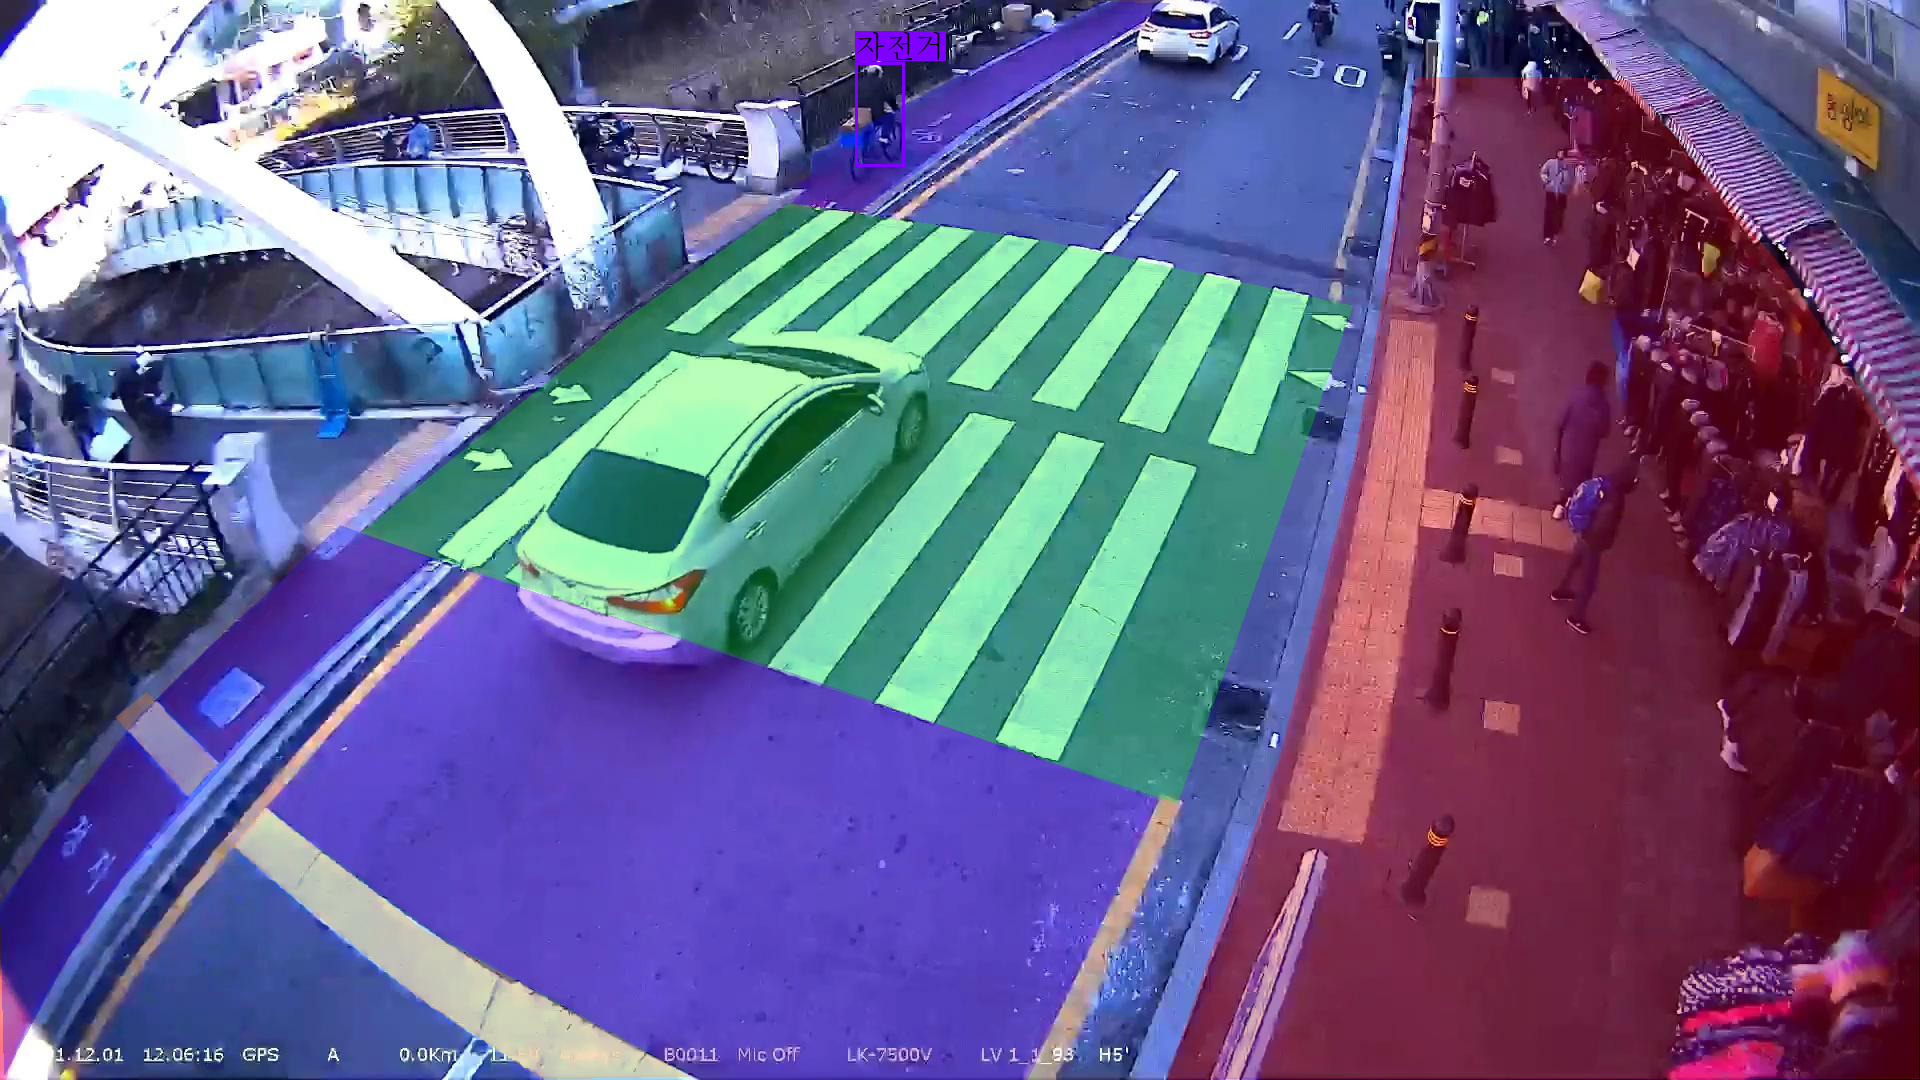

In [9]:
annot, img = random_sample()
pic_with_annotation(annot, img)
img

In [33]:
# 현재 json 형식에서 YOLO에 맞는 형태로 변환
# YOLOv5 라벨형식 : class_label, x_mid(0~1), y_mid(0~1), width(0~1), height(0~1) (txt파일)
# 현재 json 형식 : left, top, width, height


def to_yolo_format(annot):
    """
    라벨을 YOLOv5 format으로 변경해누즌 함수
    Bounding Box만 변환
    """
    img_width = annot['description']['imageWidth']
    img_height = annot['description']['imageHeight']

    string = ''
    for seg in annot['annotations']['PM']:
        label = seg['PM_code']
        left, top, width, height = seg['points']
        # 0~1 사이로 정규화
        x = (left + width/2) / img_width
        y = (top - height/2) / img_height
        width = width / img_width
        height = height / img_height

        string += f'{label}, {x}, {y}, {width}, {height}\n'
    return string[:-1]


print(to_yolo_format(annot))

23, 0.3578966797331708, 0.24928150011542877, 0.02329546191910118, 0.08205073924757693
27, 0.059656732684043576, 0.37394960753563766, 0.05889679870142048, 0.14823112584043904


In [11]:
# COCO형식으로 변환
# Train:Valid:Test = 7:2:1 로 변환
""" 파일구조
COCO
    annotations
    ...
    train
    ...
    val
    ...
    test
    ...
"""
os.makedirs(FILE_PATH + '/coco/annotations', exist_ok=True)
os.makedirs(FILE_PATH + '/coco/train', exist_ok=True)
os.makedirs(FILE_PATH + '/coco/val', exist_ok=True)
os.makedirs(FILE_PATH + '/coco/test ', exist_ok=True)

files = glob.glob(FILE_PATH + '/라벨링데이터/**/*.json', recursive=True)
random.seed(42)
random.shuffle(files)

jpgs = [i.replace('라벨링데이터', '원천데이터').replace('.json', '.jpg') for i in files]
train_count = int(len(files) * 0.7)
valid_count = int(len(files) * 0.2)
# test_counts = 0.1

# for file_path in tqdm.tqdm(jpgs[:train_count]):
#     shutil.copy(file_path, FILE_PATH + f'/coco/train/{os.path.basename(file_path).split(".")[0]}.jpg')

# for file_path in tqdm.tqdm(jpgs[train_count:train_count+valid_count]):
#     shutil.copy(file_path, FILE_PATH + f'/coco/val/{os.path.basename(file_path).split(".")[0]}.jpg')

# for file_path in tqdm.tqdm(jpgs[train_count+valid_count:]):
#     shutil.copy(file_path, FILE_PATH + f'/coco/test/{os.path.basename(file_path).split(".")[0]}.jpg')


def to_COCO(files, mode='train'):
    
    coco = {
        "categories": [
            {"id": 1, "name": "오토바이", "supercategory": "none"},
            {"id": 2, "name": "오토바이보행자도로 통행위반", "supercategory": "none"},
            {"id": 3, "name": "오토바이안전모 미착용", "supercategory": "none"},
            {"id": 4, "name": "오토바이무단횡단", "supercategory": "none"},
            {"id": 5, "name": "오토바이신호위반", "supercategory": "none"},
            {"id": 6, "name": "오토바이정지선위반", "supercategory": "none"},
            {"id": 7, "name": "오토바이횡단보도 주행위반", "supercategory": "none"},
            {"id": 8, "name": "자전거", "supercategory": "none"},
            {"id": 9, "name": "자전거 캐리어", "supercategory": "none"},
            {"id": 10, "name": "자전거보행자도로 통행위반", "supercategory": "none"},
            {"id": 11, "name": "자전거안전모 미착용", "supercategory": "none"},
            {"id": 12, "name": "자전거무단횡단", "supercategory": "none"},
            {"id": 13, "name": "자전거신호위반", "supercategory": "none"},
            {"id": 14, "name": "자전거정지선위반", "supercategory": "none"},
            {"id": 15, "name": "자전거횡단보도 주행위반", "supercategory": "none"},
            {"id": 16, "name": "킥보드", "supercategory": "none"},
            {"id": 17, "name": "킥보드 캐리어", "supercategory": "none"},
            {"id": 18, "name": "킥보드보행자도로 통행위반", "supercategory": "none"},
            {"id": 19, "name": "킥보드안전모 미착용", "supercategory": "none"},
            {"id": 20, "name": "킥보드무단횡단", "supercategory": "none"},
            {"id": 21, "name": "킥보드신호위반", "supercategory": "none"},
            {"id": 22, "name": "킥보드횡단보도 주행위반", "supercategory": "none"},
            {"id": 23, "name": "킥보드동승자 탑승위반", "supercategory": "none"}
        ],
        "images": [],
        "annotations": []
    }


    for idx, file in tqdm.tqdm(enumerate(files)):
        with open(file, 'r') as f:
            annot = json.load(f)

        coco['images'].append(
            {
            'id':idx+1,
            'file_name':os.path.basename(file).replace('json', 'jpg'),
            'height':annot['description']['imageHeight'],
            'width':annot['description']['imageWidth'],
            }
        )
        # bbox와 카테고리 변환
        for pm in annot['annotations']['PM']:
            one_object = {"image_id":idx+1,
                          "category_id":int(pm['PM_code'])-12 if int(pm['PM_code']) < 34 else int(pm['PM_code'])-13,
                          "bbox":pm['points'],
                          'area':pm['points'][2] * pm['points'][3]}

            coco['annotations'].append(one_object)

    for idx in range(len(coco['annotations'])):
        coco['annotations'][idx]['id'] = idx + 1

    with open(FILE_PATH + f"/coco/annotations/{mode}_annotations.json", "w") as json_file:
        json.dump(coco, json_file, ensure_ascii=False)


to_COCO(files[:train_count], mode='train')
to_COCO(files[train_count:train_count+valid_count], mode='valid')
to_COCO(files[train_count+valid_count:], mode='test')

# train 39496
# valid 11284
# test 5643

39496it [04:19, 152.29it/s]
11284it [01:14, 151.25it/s]
5643it [00:36, 155.39it/s]


## 기본 모델 (Faster RCNN 훈련)

In [3]:
from mmengine.config import Config
from mmengine.runner import set_random_seed
import mmcv

# Faster RCNN R-50-FPN (FP16) 모델 설정
config_file = 'mmdetection/configs/faster_rcnn/faster-rcnn_r50_fpn_amp-1x_coco.py'

cfg = Config.fromfile(config_file)

ds_type = 'CocoDataset'
classes = tuple(LABEL_NAMES[12:])

cfg['data_root'] = 'data/coco/'
# 메타정보에 클래스와 컬러 입력
cfg.metainfo = {
    'classes':classes,
    'pallete':COLORS[:23]
}
# ROI head의 클래스 숫자도 변경
cfg.model.roi_head.bbox_head.num_classes = 23

# 데이터로더 세팅. 
# ipynb 환경이면 num_workers=0, persistent_workers=False로 맞출것! .py이면 보통 gpu갯수*4 정도)
cfg.train_dataloader.dataset.update(
    {'data_prefix':{'img':'train/'},
     'ann_file':'annotations/train_annotations.json',
     'data_root':cfg.data_root,
     'metainfo':cfg.metainfo}
)
cfg.train_dataloader.update({'batch_size':16, 'num_workers':0, 'persistent_workers':False})

cfg.val_dataloader.dataset.update(
    {'data_prefix':{'img':'val/'},
     'ann_file':'annotations/valid_annotations.json',
     'data_root':cfg.data_root,
     'metainfo':cfg.metainfo}
)
cfg.val_dataloader.update({'num_workers':0, 'persistent_workers':False})

cfg.test_dataloader.dataset.update(
    {'data_prefix':{'img':'test/'},
     'ann_file':'annotationsss/test_annotations.json',
     'data_root':cfg.data_root,
     'metainfo':cfg.metainfo}
)
cfg.test_dataloader.update({'num_workers':0, 'persistent_workers':False})

cfg.val_evaluator.ann_file = cfg.data_root + cfg.val_dataloader.dataset.ann_file
cfg.test_evaluator.ann_file = cfg.data_root + cfg.test_dataloader.dataset.ann_file

# pre-trained모델 불러오는 경로와, 작업물 경로 설정
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_fp16_1x_coco_20200204-d4dc1471.pth'
cfg.work_dir = './output'

# 검증 인터벌과 체크포인트 저장 인터벌, 로그 인터벌 설정
cfg.train_cfg.val_interval = 3
cfg.default_hooks.checkpoint.interval = 5
cfg.default_hooks.logger.interval = 10

# 학습률 조정 (SGD)
cfg.optim_wrapper.optimizer.lr = .02

# 랜덤시드 설정. 단, 완전 결정적이진 않게(왜 그런지 이유는 아직 모름)
set_random_seed(42, deterministic=False)

# 텐서보드 시각화 벡엔드 추가
cfg.visualizer.vis_backends.append({'type':'TensorboardVisBackend'})

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)
runner.train()

In [8]:
!python faster_rcnn.py

Traceback (most recent call last):
  File "c:\Users\dynam\Desktop\AIB\AIB_TP\AIB_TP2\faster_rcnn.py", line 104, in <module>
    runner = Runner.from_cfg(cfg)
             ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dynam\anaconda3\envs\TP2\Lib\site-packages\mmengine\runner\runner.py", line 445, in from_cfg
    runner = cls(
             ^^^^
  File "c:\Users\dynam\anaconda3\envs\TP2\Lib\site-packages\mmengine\runner\runner.py", line 386, in __init__
    self._log_env(env_cfg)
  File "c:\Users\dynam\anaconda3\envs\TP2\Lib\site-packages\mmengine\runner\runner.py", line 2336, in _log_env
    env = collect_env()
          ^^^^^^^^^^^^^
  File "c:\Users\dynam\anaconda3\envs\TP2\Lib\site-packages\mmengine\utils\dl_utils\collect_env.py", line 119, in collect_env
    env_info['MSVC'] = cc.decode(encoding).partition('\n')[0].strip()
                       ^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc3 in position 20: invalid continuation byte
